In [46]:
# Import packages
import pandas as pd
import numpy as np
import keras
import os

# Images
from matplotlib import pyplot 
from matplotlib.image import imread

In [47]:
# Set plot size
pyplot.rcParams['figure.figsize'] = [15, 10]

In [48]:
def plot_first_nine(folder = 'train-jpg/'):
    '''
    Input: File path to training data.
    Output: Plot of first 9 images in training data.
    
    We plot 9 images because otherwise we will have to
    write formatting code for the sub-plot which is not
    worth the time.
    '''
    for i in range(9):
        # pyplot.subplot takes 3 digit code 
        # The first number is the number of rows
        # The second number is the number of columns
        # The third number is the position in the subplot 
        pyplot.subplot(340 + 1 + i)
        # Define filename
        filename = folder + 'train_' + str(i) + '.jpg'
        # Load image pixels
        image = imread(filename)
        # Plot raw pixel data
        pyplot.imshow(image)
    # Show the figure
    pyplot.show()
    # End the function
    return

In [49]:
def load_mapping_data(file_name = 'train_v2.csv'):
    '''
    Input: mapping file name
    Output: mapping file data-frame
    '''
    mapping = pd.read_csv(file_name)
    print(mapping.shape)
    print(mapping.head())
    return(mapping)

In [50]:
def create_tag_mapping(mapping):
    '''
    Input: mapping data-frame
    Output: Dictionary mapping labels to integers.
    '''
    # Initialize labels
    # Labels is a set so calling update will not affect uniqueness
    labels = set()
    
    # Loop through the data-frame
    # Split the tag values on spaces
    # Then update the set with the tags
    for i in range(len(mapping)):
        tags = mapping['tags'][i].split(' ')
        labels.update(tags)
    
    # Turn into a list and sort
    labels = list(labels)
    labels.sort()
    
    # First relate labels to integers
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    
    # Return statement
    return(labels_map, inv_labels_map)

In [51]:
def create_file_mapping(mapping_df):
    '''
    Input: mapping data-frame
    Output: mapping dictionary of filename to tags
    '''
    # Initialize the dictionary
    mapping = dict()
    # Iterate through the data-frame range
    for i in range(len(mapping_df)):
        # Store names and tags
        name, tags = mapping_df['image_name'][i], mapping_df['tags'][i]
        # Put them in the dictionary as name:tag key value pairs
        mapping[name] = tags.split(' ')
    
    # Return mapping
    return mapping

In [52]:
def one_hot_encode(tags, mapping):
    '''
    There are 17 elements in tag. 
    We want a 17 element vector of 0s and 1s.
    Each element should be 1 if the corresponding
    category is in the image file and 0 otherwise.
    '''
    # Create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # Mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [53]:
def load_dataset(path, file_mapping, tag_mapping, target_size = (128, 128)):
    '''
    Inputs: 1) Folder: Path to training folder
            2) Images file path: Path to training data images within training folder
            3) File mapping: Mapping of training images to their labels
            4) Tag mapping:  One to one mapping of labels to integers
            5) Target size:  Size that input images should be cropped to
    Output: 1) Training data and labels as numpy arrays of unsigned integers
    
    Why is path separately specified? 
    IMO this is to ensure that if images are stored remotely like on Amazon S3 or another data-store 
    away from the local machine then this parameter can be easily changed to get data from there. 
    '''
    # Photos and targets stored here
    photos, targets = list(), list()
    # Enumerate files in the directory
    for filename in os.listdir(folder):
        # Load image
        photo = keras.preprocessing.image.load_img(path + filename, target_size=target_size)
        # Convert to numpy array
        photo = keras.preprocessing.image.img_to_array(photo, dtype='uint8')
        # Get tags
        tags = file_mapping[filename[:-4]]
        # One hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # Store photos 
        photos.append(photo)
        # Store targets
        targets.append(target) 
    # We know color channel values go from 0 to 255 and will not be negative
    # Convert to arrays while making data type unsigned
    # Unsigned integer saves space 
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return(X, y)

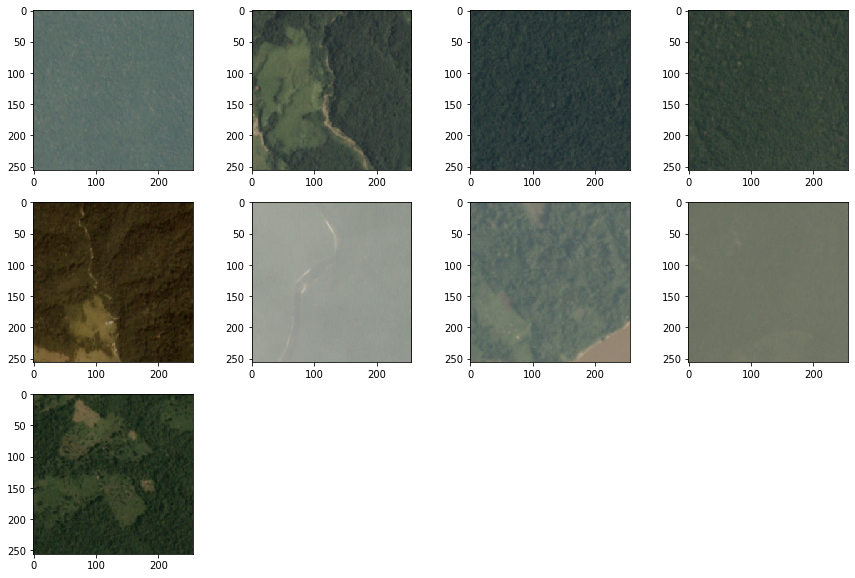

(40479, 2)
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
(40479, 32, 32, 3) (40479, 17)


In [54]:
if __name__ == '__main__':
    
    # Plot the first nine images
    plot_first_nine()
    # Create mapping data-frame
    mapping_df = load_mapping_data()
    # Create tag mapping
    labels_map, inv_labels_map = create_tag_mapping(mapping_df)
    # Create file mapping
    mapping = create_file_mapping(mapping_df)

    # Path to training data
    path = '/Users/akshatgoel/Documents/code/planet-rep/'
    # Load the jpeg images
    folder = 'train-jpg/'
    # Set the target_size
    target_size = (32, 32)
    
    # Load data-set
    X, y = load_dataset(folder, mapping, labels_map, target_size)
    # Print X.shape, y.shape
    print(X.shape, y.shape)
    # Save both arrays to one file in compressed format
    np.savez_compressed('planet_data.npz', X, y)